In [1]:
import os
import colorsys
import numpy as np
import random
import pandas as pd
from scipy import stats
from collections import defaultdict

from scipy.spatial import cKDTree

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import py3Dmol

from Bio.PDB import PDBIO, PDBParser, Select
from Bio.PDB.Chain import Chain
from Bio.PDB.Residue import Residue

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

# Structure preparation for processing with PocketMiner

This norebook describes steps necessary to prepare protein strutures with several chains for processing with PocketMiner model (https://pocketminer.azurewebsites.net) using the example of SARS-CoV-2 Spike protein.

To begin with, separate folders were created for each pdb file downloaded from the RSCB PDB database. The folders are named by PDB id number and the state of RBD in that structure.

In [2]:
# dictionary to convert residue names to single letter notation
three_to_one_leter_name = {
                           "GLY": "G",
                           "ALA": "A",
                           "VAL": "V",
                           "LEU": "L",
                           "ILE": "I",
                           "SER": "S",
                           "THR": "T",
                           "MET": "M",
                           "CYS": "C",
                           "ASN": "N",
                           "GLN": "Q",
                           "ASP": "D",
                           "GLU": "E",
                           "LYS": "K",
                           "ARG": "R",
                           "HIS": "H", "HSD": "H", "HSE": "H", "HSP": "H",
                           "PHE": "F",
                           "TRP": "W",
                           "TYR": "Y",
                           "PRO": "P",
                           }

In [3]:
# list files for analysis
# folder name + PDB id

pdb_dirs = [x for x in os.listdir('.')]

files = []
for pdb_dir in pdb_dirs:
    if (not '.' in pdb_dir) and ('_' in pdb_dir):
        row = [pdb_dir, pdb_dir.split('_')[0].lower()]
        files.append(row)
files

[['7DDD_locked', '7ddd'],
 ['7K4N_up', '7k4n'],
 ['7KNI_up', '7kni'],
 ['6VXX_closed', '6vxx'],
 ['6ZP0_closed', '6zp0'],
 ['7KJ4_up', '7kj4'],
 ['6ZB5_locked', '6zb5'],
 ['7KSG_up', '7ksg'],
 ['7A98_up', '7a98'],
 ['6X29_closed', '6x29'],
 ['6ZGE_locked', '6zge'],
 ['6XR8_locked', '6xr8'],
 ['6X6P_closed', '6x6p'],
 ['6X2C_closed', '6x2c'],
 ['6ZB4_locked', '6zb4']]

In [4]:
# manually sort them so that order of the rows in generated dataframe is convenient
files = [
 ['7K4N_up', '7k4n'],
 ['7KNI_up', '7kni'],
 ['7KJ4_up', '7kj4'],
 ['7KSG_up', '7ksg'],
 ['7A98_up', '7a98'],
    
 ['6VXX_closed', '6vxx'],
 ['6ZP0_closed', '6zp0'],
 ['6X29_closed', '6x29'],
 ['6X6P_closed', '6x6p'],
 ['6X2C_closed', '6x2c'],
    
 ['6ZB5_locked', '6zb5'],
 ['6ZGE_locked', '6zge'],
 ['6XR8_locked', '6xr8'],
 ['6ZB4_locked', '6zb4'],
 ['7DDD_locked', '7ddd']
]

## 0. Extract the desired protein

This step is done manually. Open each structure in Chimera (or any other molecular viewer), select the desired protein and save it separately as `PDBid_protein.pdb` to omit glycans, water molecules and other binding partners.

## 1. Chain renumbering

The end goal is to edit structures so that there is only one chain.

First, we have to renumber residues in multimers.

In [156]:
for file, pdb_id in files:
    
    #############
    pdb_to_load = f'{file}/{pdb_id}_protein.pdb'
    pdb_to_save = f'{file}/{pdb_id}_renumbered.pdb'
    #############

    # read structure
    io = PDBIO()
    parser = PDBParser()
    trimer_structure = parser.get_structure('trimer', pdb_to_load)

    # renumber residues in trimer_structure
    # we will start renumbering from the second chain
    last_A_res_id = 0
    renumbered_residues = []
    n_residues_renumbered = 0

    first_chain = ''
    for model in trimer_structure:
        for chain in model:

            if len(first_chain) == 0:
                first_chain = chain.id

            for residue in chain:

                if chain.id == first_chain:
                    last_A_res_id = residue.id[1]
                else:

                    if not (chain.id, residue.id) in renumbered_residues:
                        renumbered_residues.append((chain.id, residue.id))
                        n_residues_renumbered += 1

                    # change residue id
                    residue.id = (residue.id[0],
                                  last_A_res_id + n_residues_renumbered,
                                  residue.id[2])

    io.set_structure(trimer_structure)
    io.save(pdb_to_save,  preserve_atom_numbering=True) 

## 2. Clean disordered atoms

This problem was originally found for 6ZGE structure, but ideally this step should be ran on all structures

In [48]:
# for file, pdb_id in files:
for file, pdb_id in files:
    
    #############
    pdb_to_load = f'{file}/{pdb_id}_renumbered.pdb'
    pdb_to_save = f'{file}/{pdb_id}_renumbered.pdb'
    #############

    parser = PDBParser()
    s = parser.get_structure("structure", pdb_to_load)

    # keeps alt loc A and eliminates the loc ID
    class NotDisordered(Select):
        def accept_atom(self, atom):
            if (not atom.is_disordered()) or atom.get_altloc() == 'A':
                atom.set_altloc(" ")  # Eliminate alt location ID before output.
                return True
            else:  
                # Alt location was not one to be output.
                return False

    io = PDBIO()
    io.set_structure(s)
    io.save(pdb_to_save, select = NotDisordered())

## 3. Rename all chains to A for PocketMiner processing

This step is also better done manually. 
Each structure `PDBid_renumbered.pdb` is opened in PyMol and the chains are renamed by executing following commands:

Now the structure should be saved as `PDBid_renumbered_chains_A.pdb`

## 4. Read PocketMiner and fpocket processing and data collection

Pocket Miners runs were conducted on structures `PDBid_renumbered_chains_A.pdb` by consecutively submitting these to https://pocketminer.azurewebsites.net. The output files were deposited to structures' folders and named as `PDBid_PocketMiner.pdb`

Also each structure was processed with fpocket.
The bash script was generated as shown below:

In [61]:
# generate script for fpocket
cwd = os.getcwd()
with open('fpocket_runs.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("\n")
    for file, pdb_id in files:
        f.write(f"cd {cwd}/{file}\n")
        f.write(f"fpocket -f {pdb_id}_renumbered_chains_A.pdb\n")
        f.write("\n")

In order to align predictions between different structures let's first perform a sequence alignment.

`S_protein.fasta` contains a reference Spike protein sequence used for alignment

In [5]:
# read Spike sequence to compare
Spike_protein = ''
with open('S_protein.fasta', 'r') as f:
    for line in f:
        if not line.startswith('>'):
            Spike_protein += line.strip()
            
# convert into dictionary
Spike_protein_residues = {i+1:Spike_protein[i] for i in range(len(Spike_protein))}

Next, we need to get protein sequences from each file:

In [41]:
# read data from each file
chain_sequences = []
for file, pdb_id in files:
    parser = PDBParser()
    trimer_structure = parser.get_structure('trimer',
                                            f"{file}/{pdb_id}_protein.pdb")

    for model in trimer_structure:
        for chain in model:
            chain_sequence = ''
            
            for residue in chain:
                chain_sequence += three_to_one_leter_name[residue.get_resname()]
            
            chain_sequences.append([f"{file}_{chain.id}", chain_sequence])

# save all of that intp fasta
with open('Spike_sequences.fasta', 'w') as f:
    f.write(">Spike_protein\n")
    f.write(f"{Spike_protein}\n")
    for seq in chain_sequences:
        f.write(f">{seq[0]}\n")
        f.write(f"{seq[1]}\n")

The sequences from `Spike_sequences.fasta` were aligned in UGENE using MUSCLE algorithm. The alignment was inspected manually and and exported as FASTA file `Spike_sequences_aligned.fa`

In [65]:
# read aligned sequences from FASTA file
aligned_sequences = {}
with open('Spike_sequences_aligned.fa', 'r') as f:
    seq = ''
    for line in f:
        if line.startswith('>'):
            if len(seq) > 0:
                aligned_sequences[name] = seq
                seq = ''  
            name = line.strip()[1:]
        else:
            seq += line.strip()
            
    if len(seq)> 0:
        aligned_sequences[name] = seq

**Now we are ready to organise Picket Miner and fpocket data into matrices:**

In [67]:
# read PM data from PDB file 
def read_PM_data(file):
    PM_data = []
    PM_res_inds = []
    with open(file, 'r') as f:
        for line in f:
            if "ATOM" in line:
                data = line.split()
                res_prob = float(data[-2])
                res_name = three_to_one_leter_name[data[3]]
                res_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])
                if res_id not in PM_res_inds:
                    PM_res_inds.append(res_id)
                    PM_data.append((res_prob, res_name))
    return PM_data, PM_res_inds

# read fpocket data from txt and PDB file
def read_fpocket_data(fpocket_out, distance_threshold=4):
    
    fpocket_out_name = fpocket_out.split('/')[-1]
    
    # get protein and pocket coordinates from the structure
    protein_atoms_residues = [] # list of residue ids for each atom
    protein_atoms_coords = [] # coordinate matrix for each atom
    pocket_atoms_pockets = [] # list of pocket ids for each pocket atom
    pocket_atoms_coords = [] # coordinate matrix of pocket atoms
    out = f"{fpocket_out}/{fpocket_out_name}.pdb"
    with open(out, 'r') as f:
        for line in f:
            data = line.split()
            # read ptotein atom data
            if line.startswith('ATOM'):
                res_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])
                protein_atoms_residues.append(res_id)
                protein_atoms_coords.append([float(data[-7]), float(data[-6]), float(data[-5])])
            # read pocket atom data
            elif line.startswith('HETATM'):
                pocket_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])
                pocket_atoms_pockets.append(pocket_id)
                pocket_atoms_coords.append([float(data[-6]), float(data[-5]), float(data[-4])])


    # construct binary trees
    protein_atoms_residues = np.array(protein_atoms_residues)
    protein_tree = cKDTree(np.array(protein_atoms_coords))
    pocket_tree = cKDTree(np.array(pocket_atoms_coords))

    # compute distances with a cut-off
    dist = pocket_tree.sparse_distance_matrix(protein_tree,
                                              max_distance = distance_threshold)
    dist = dist.toarray()

    # iterate over pocket atoms and record pocket for each residue if any
    residues_pockets = dict()
    for i in range(dist.shape[0]):

        # current pocket id
        cur_pocket = pocket_atoms_pockets[i]

        # nearby protein atoms
        close_atoms_indices = dist[i, :].nonzero()[0]

        # check residue for each nearby atom
        for res_id in protein_atoms_residues[close_atoms_indices]:
            residues_pockets[res_id] = cur_pocket

    # read volume for each pocket
    data_file = f"{fpocket_out}/{fpocket_out_name[:-4]}_info.txt"
    pockets_data = {}
    with open(data_file, 'r') as f:
        for line in f:
            if line.startswith('Pocket'):
                pocket_id = int(line.split()[1])
            elif 'Volume :' in line:
                vol = float(line.split()[-1])
                pockets_data[pocket_id] = vol
                
    return residues_pockets, pockets_data 

In [69]:
# matrix to collect data on Pocket Miner residue pribabilities
# -1 will correspond to the residues without any probability
PocketMiner_data = np.zeros((len(aligned_sequences) - 1, len(Spike_protein)))
PocketMiner_data[:,:] = -1
PocketMiner_data_index = []

# matrices to collect fpocket data
# -1 will correspond to the residues without pocket
pocket_contact_matrix = np.zeros((len(aligned_sequences) - 1, len(Spike_protein)))
pocket_contact_matrix[:, :] = -1
pocket_volume_matrix  = np.zeros((len(aligned_sequences) - 1, len(Spike_protein)))
pocket_volume_matrix[:, :]  = -1

# collect data from each file
row = 0 # row index for PM data matrix
for file, pdb_id in files:
    
    print('Processing: ', file, pdb_id)
    
    # read PocketMiner data
    PM_data, PM_res_inds = read_PM_data(f'{file}/{pdb_id}_PocketMiner.pdb')
    
    # read fpocket data
    fpocket_out = f"{file}/{pdb_id}_renumbered_chains_A_out"
    residues_pockets, pockets_data = read_fpocket_data(fpocket_out)

    # parse original protein stucture with multiple chains
    # to relate residue indexes to sequences etc
    parser = PDBParser()
    trimer_structure = parser.get_structure('trimer',
                                            f"{file}/{pdb_id}_protein.pdb")
    
    i = 0 # sequential index of residue in original structure
    for model in trimer_structure:
        for chain in model:
            
            # we are parsing this chain now
            PocketMiner_data_index.append(f"{file}_{chain.id}")
            
            # get aligned sequence
            seq_aligned = aligned_sequences[f"{file}_{chain.id}"]
            
            # get unaligned sequence to compare later
            seq_unaligned = seq_aligned.replace('-', '')
            
            # get matrix indices of the residues
            res_indices, res_to_skip = [], []
            for k, (res, ref_res) in enumerate(zip(seq_aligned, Spike_protein)):
                if res != '-':
                    res_indices.append(k)
                if res != ref_res:
                    res_to_skip.append(k)
            
            # for each residue record PM and f pcoket data if its correct
            chain_seq = ''
            for j, residue in enumerate(chain):
                
                residue_name = three_to_one_leter_name[residue.get_resname()]
                chain_seq += residue_name
                
                # sequence check
                if residue_name != PM_data[i][1]:                                       
                    print(file, residue_name, residue.id[1], PM_data[i])
                # if sequence is alrigth add element to matrix
                else:
                    ind = res_indices[j]
                    if ind not in res_to_skip:
                        
                        # record PM data
                        PocketMiner_data[row, ind] = PM_data[i][0]
                        
                        # record pocket data if any
                        if PM_res_inds[i] in residues_pockets.keys():
                            pocket_id = residues_pockets[PM_res_inds[i]]
                            pocket_contact_matrix[row, ind] = pocket_id
                            pocket_volume_matrix[row, ind]  = pockets_data[pocket_id]
                        else:
                            pocket_contact_matrix[row, ind] = 0
                            pocket_volume_matrix[row, ind]  = 0
                        
                # update index 
                i += 1
                        
            # chain processed, switch to new row and check sequence
            row += 1
            if chain_seq != seq_unaligned:
                print(f"Problems with {file}_{chain.id}")

Processing:  7K4N_up 7k4n
Processing:  7KNI_up 7kni
Processing:  7KJ4_up 7kj4
Processing:  7KSG_up 7ksg
Processing:  7A98_up 7a98
Processing:  6VXX_closed 6vxx
Processing:  6ZP0_closed 6zp0
Processing:  6X29_closed 6x29
Processing:  6X6P_closed 6x6p
Processing:  6X2C_closed 6x2c
Processing:  6ZB5_locked 6zb5
Processing:  6ZGE_locked 6zge
Processing:  6XR8_locked 6xr8
Processing:  6ZB4_locked 6zb4
Processing:  7DDD_locked 7ddd


In [70]:
# crop columns without any data

columns = [str(i) for i in range(1, PocketMiner_data.shape[1] + 1)]
min_col, max_col = 0, 0
encountered_non_empty = False
for i in range(PocketMiner_data.shape[1]):
    if sum(PocketMiner_data[:, i] != -1) > 0:
        if i > max_col:
            max_col = i
        encountered_non_empty = True
    else:
        if not encountered_non_empty:
            min_col = i
            
columns = columns[min_col+1:max_col + 1]
PocketMiner_data_cropped = PocketMiner_data[:, min_col+1:max_col + 1]
pocket_contact_matrix_cropped = pocket_contact_matrix[:, min_col+1:max_col + 1]
pocket_volume_matrix_cropped = pocket_volume_matrix[:, min_col+1:max_col + 1]

# save matrices
PocketMiner_df = pd.DataFrame(data=PocketMiner_data_cropped,
                              columns=columns,
                              index=PocketMiner_data_index)

pocket_contact_df = pd.DataFrame(data=pocket_contact_matrix_cropped,
                                 columns=columns,
                                 index=PocketMiner_data_index)

pocket_volume_df = pd.DataFrame(data=pocket_volume_matrix_cropped,
                                columns=columns,
                                index=PocketMiner_data_index)

PocketMiner_df.to_csv('data/PocketMiner_data.csv')
PocketMiner_df.to_excel('data/PocketMiner_data.xlsx')

pocket_contact_df.to_csv('data/fpocket_contact_data.csv')
pocket_contact_df.to_excel('data/fpocket_contact_data.xlsx')

pocket_volume_df.to_csv('data/fpocket_volume_data.csv')
pocket_volume_df.to_excel('data/fpocket_volume_data.xlsx')

In [6]:
# reload saved data

PocketMiner_df = pd.read_csv('data/PocketMiner_data.csv', index_col=0)
pocket_contact_df = pd.read_csv('data/fpocket_contact_data.csv', index_col=0)
pocket_contact_df = pocket_contact_df.loc[:, :].astype(int)
pocket_volume_df = pd.read_csv('data/fpocket_volume_data.csv', index_col=0)

PocketMiner_df.head()

,14,15,16,17,18,19,20,21,22,23,...,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162
7K4N_up_A,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7K4N_up_B,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7K4N_up_E,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7KNI_up_A,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7KNI_up_B,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


<AxesSubplot:>

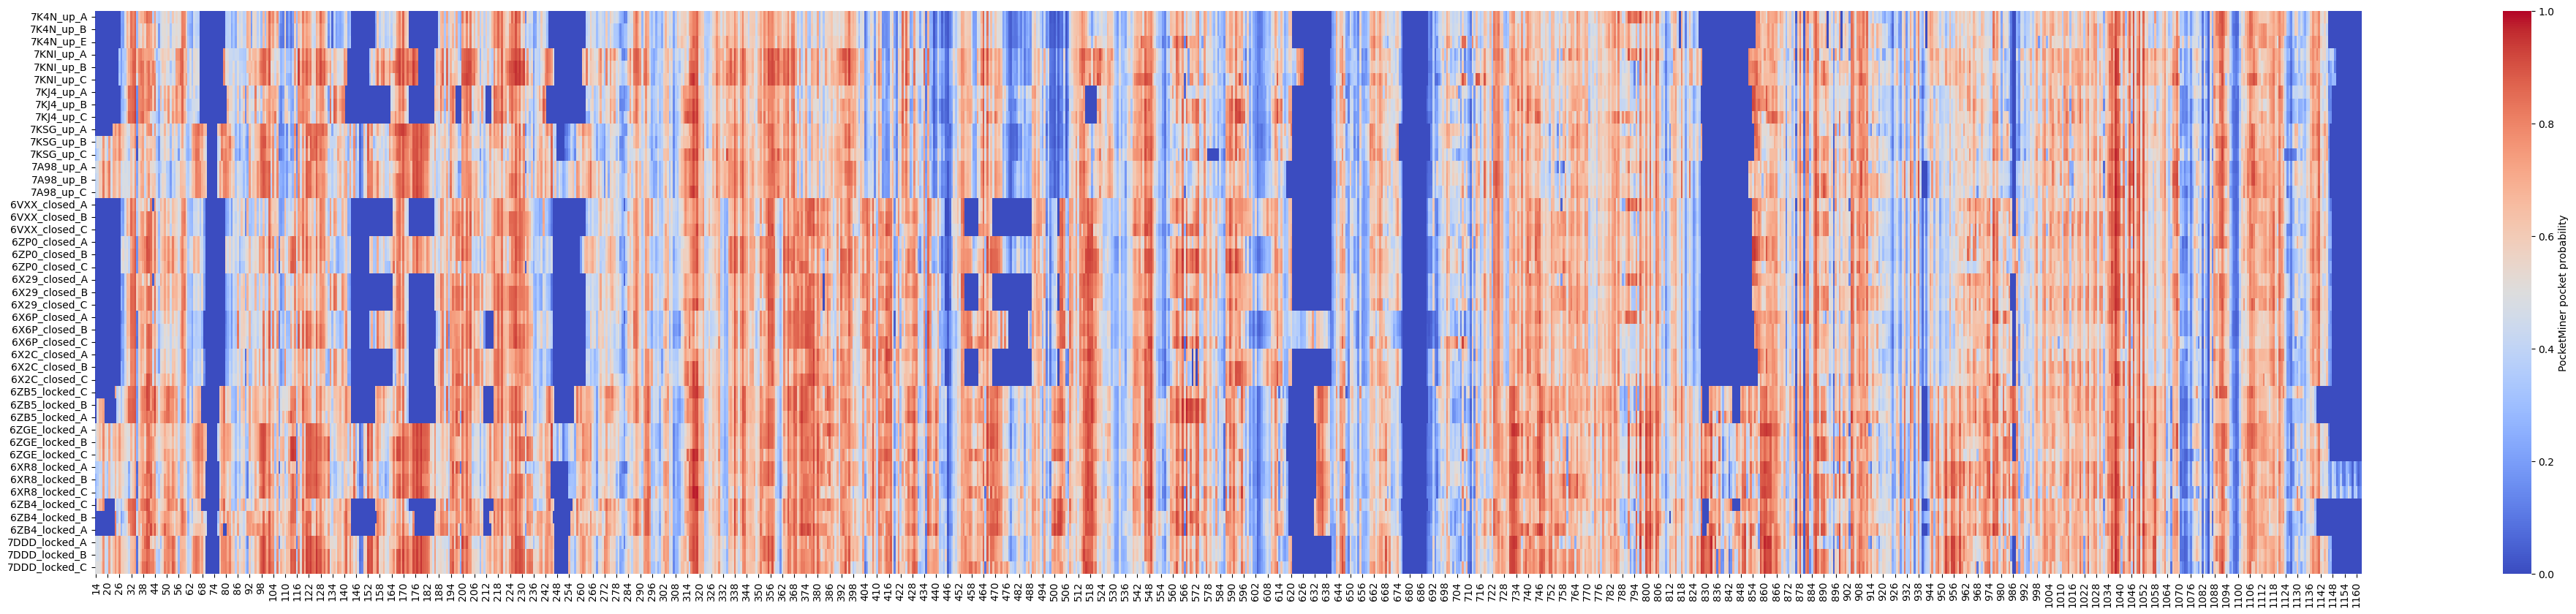

In [72]:
# quickly visualise the Pocket Miner matrix

plt.figure(figsize=(50, 10))
sns.heatmap(PocketMiner_df,
            vmin=0, vmax=1,
            cmap='coolwarm',
            cbar_kws={'label': 'PocketMiner pocket probability'})